Isochrone generation took 1.204639 s.
Making photometry for isochrone: log(t) = 6.00  AKs = 0.70  dist = 4500
     Starting at:  2025-02-11 01:54:07.424812   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F162M = 23.11
Starting filter: jwst,F182M   Elapsed time: 0.60 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F182M = 23.10
Starting filter: jwst,F200W   Elapsed time: 1.18 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F200W = 22.85
      Time taken: 1.77 seconds
Isochrone generation took 1.133230 s.
Making photometry for isochrone: log(t) = 6.18  AKs = 0.70  dist = 4500
     Starting at:  2025-02-11 01:54:10.343420   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2292 K  m_jwst_F162M = 23.47
Starting filter: jwst,F182M   Elapsed time: 0.6

Starting filter: jwst,F200W   Elapsed time: 1.19 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1814 K  m_jwst_F200W = 24.78
      Time taken: 1.78 seconds
Changing to logg=5.00 for T=  1773 logg=4.01
Isochrone generation took 1.126976 s.
Making photometry for isochrone: log(t) = 6.88  AKs = 0.70  dist = 4500
     Starting at:  2025-02-11 01:54:45.685833   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F162M = 25.40
Starting filter: jwst,F182M   Elapsed time: 0.61 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F182M = 25.31
Starting filter: jwst,F200W   Elapsed time: 1.21 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F200W = 24.89
      Time taken: 1.81 seconds
Changing to logg=5.00 for T=  1711 logg=4.02
Isochrone generation took 1.109021 s.
Making photometry for isochrone: log(t) = 6.90  AKs = 0.70  dist = 4500

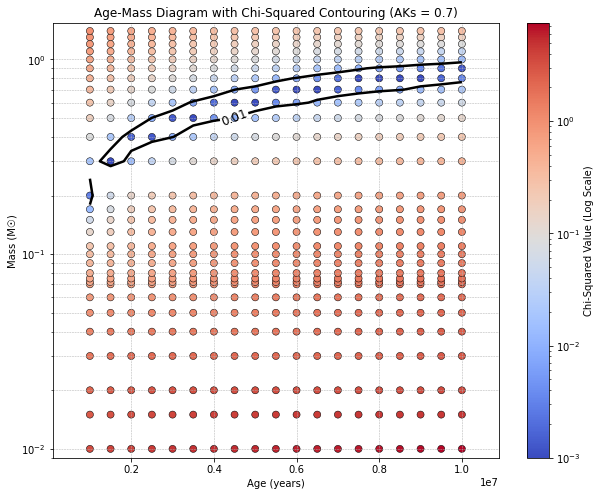

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from spisea import synthetic, evolution, atmospheres, reddening
from spisea.imf import imf, multiplicity
from matplotlib.colors import LogNorm
import csv

# Paths for isochrones
iso_dir = 'isochrones/'

# Estimation variables
star_index = 0  # Set which star in the CSV to analyze

# Define isochrone parameters
dist = 4500
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawCardelli(3.1)
filt_list = ['jwst,F162M', 'jwst,F182M', 'jwst,F200W']
filters = ['m_jwst_F162M', 'm_jwst_F182M', 'm_jwst_F200W']
metallicity = 0
level_ages = np.linspace(1, 10, 19) * 1e6  # Define age array
log_age_arr = np.log10(level_ages)
AKs = 0.7

# Load sample magnitudes, skipping the header row
sample_mags = []
with open('../../s284-no-errors.csv', mode='r') as file:
    csvFile = csv.reader(file)
    next(csvFile)  # Skip header row
    for lines in csvFile:
        sample_mags.append([float(x) for x in lines])

# Chi-square minimization function
def chi_square_reverse_model(iso_grid, sample_mags):
    chi_square_grid = np.zeros((len(iso_grid), len(iso_grid[0].points)))
    for i, iso in enumerate(iso_grid):
        for j, star in enumerate(iso.points):
            chi_square_grid[i, j] = sum(
                ((sample_mags[k] - star[filters[k]]) ** 2) / star[filters[k]]
                for k in range(len(filters))
            )
    return chi_square_grid

# Ensure directory exists
os.makedirs(iso_dir, exist_ok=True)

# Clear previous isochrones
for file in os.listdir(iso_dir):
    os.remove(os.path.join(iso_dir, file))

# Generate isochrone grid
instances = np.array([
    synthetic.IsochronePhot(log_age, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                            iso_dir=iso_dir)
    for log_age in log_age_arr
])

# Compute chi-square for each point
chi_square_values = chi_square_reverse_model(instances, sample_mags[star_index])

# Extract mass values for each isochrone
masses = np.array([[star['mass'] for star in iso.points] for iso in instances])

# Plot single diagram
fig, ax = plt.subplots(figsize=(10, 8))
norm = LogNorm(vmin=max(np.min(chi_square_values), 1e-3), vmax=np.max(chi_square_values))
cmap = plt.get_cmap('coolwarm')

# Scatter plot with chi-square coloring on a logarithmic scale
sc = ax.scatter(
    np.repeat(level_ages, chi_square_values.shape[1]), 
    masses.flatten(),
    c=chi_square_values.flatten(), cmap=cmap, norm=norm, s=50, edgecolor='k', linewidth=0.5
)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Chi-Squared Value (Log Scale)')

# Contour plot at chi-square = 0.1
contour = plt.contour(level_ages, masses[0], chi_square_values.T, levels=[0.01], colors=['black'], linewidths=2.5)
ax.clabel(contour, inline=True, fontsize=12)

# Apply logarithmic scale to y-axis
ax.set_yscale('log')

# Add labels, grid, and legend
ax.set_xlabel('Age (years)')
ax.set_ylabel('Mass (M☉)')
ax.set_title(f'Age-Mass Diagram with Chi-Squared Contouring (AKs = {AKs})')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adjust grid for log scale

# Add padding to axis limits
x_padding = 0.1 * (level_ages[-1] - level_ages[0])  # 10% padding
y_padding_factor = 0.1  # 10% padding for log scale
ax.set_xlim(level_ages[0] - x_padding, level_ages[-1] + x_padding)
ax.set_ylim(np.min(masses) * (1 - y_padding_factor), np.max(masses) * (1 + y_padding_factor))

plt.show()
